# TOC entitlements near bus/rail lines
* Subset: parcels with TOC entitlements only
* Using reconstructed TOC Tiers map, we assign developments to specific transit lines.
* Which bus/rail lines or rail stations have seen the most TOC entitlement activity?
* TOC entitlement activity by bus/rail line & tier
* TOC entitlement activity by rail line

In [2]:
import boto3
import geopandas as gpd
import intake
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xlsxwriter
import utils

from IPython.display import display, Markdown

In [3]:
catalog = intake.open_catalog("../catalogs/*.yml")

s3 = boto3.client('s3')
bucket_name = 'city-planning-entitlements'

## Assign entitlements to conditions

In [4]:
toc_tiers = utils.reconstruct_toc_tiers_file()

parcels = catalog.toc_parcels_with_entitlements.read().to_crs("EPSG:4326")

In [5]:
toc_parcels = parcels[parcels.num_TOC > 0]

In [5]:
df = utils.parcels_join_toc_tiers(toc_parcels, toc_tiers)

## Which rule?

In [6]:
tier_1 = df[df.TOC_Tier == 1]
tier_2 = df[df.TOC_Tier == 2]
tier_3 = df[df.TOC_Tier == 3]
tier_4 = df[df.TOC_Tier == 4]

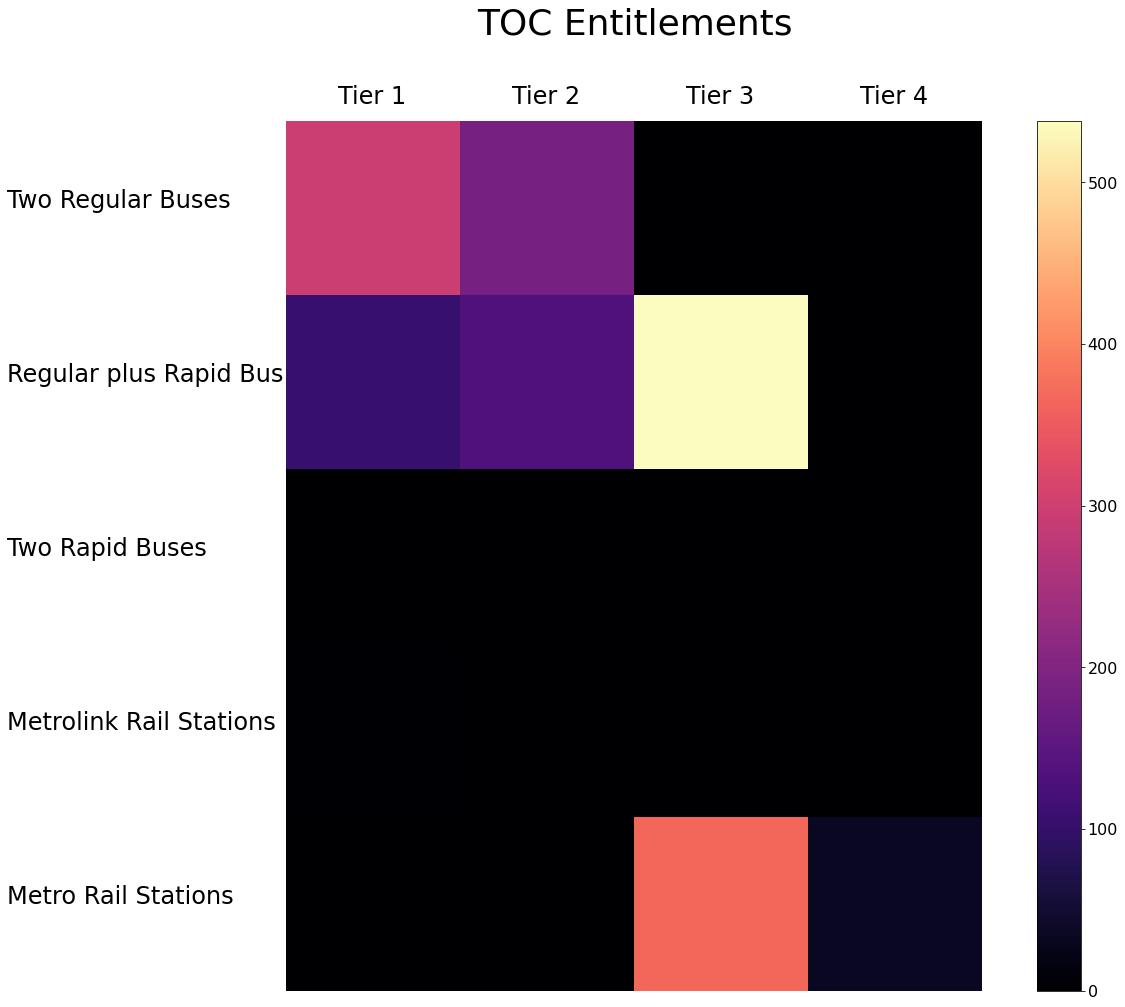

In [7]:
table = np.zeros(shape=(5, 4))
table[4,3] = tier_4[(tier_4.mode_a=="metro") & (tier_4.mode_b.isin(["metro", "bus"]))].num_TOC.sum()
table[4,2] = tier_3[tier_3.mode_a=="metro"].num_TOC.sum()
table[3,2] = tier_3[tier_3.mode_a=="metrolink"].num_TOC.sum()
table[3,1] = tier_2[tier_2.mode_a=="metrolink"].num_TOC.sum()
table[3,0] = tier_1[tier_1.mode_a=="metrolink"].num_TOC.sum()
table[2,2] = tier_3[tier_3.a_rapid & tier_3.b_rapid].num_TOC.sum()
table[2,1] = tier_2[tier_2.a_rapid & tier_2.b_rapid].num_TOC.sum()
table[1,2] = tier_3[tier_3.a_rapid ^ tier_3.b_rapid].num_TOC.sum()
table[1,1] = tier_2[tier_2.a_rapid ^ tier_2.b_rapid].num_TOC.sum()
table[1,0] = tier_1[tier_1.a_rapid ^ tier_1.b_rapid].num_TOC.sum()
table[0,1] = tier_2[~tier_2.a_rapid & ~tier_2.b_rapid].num_TOC.sum()
table[0,0] = tier_1[~tier_1.a_rapid & ~tier_1.b_rapid].num_TOC.sum()


fig, ax = plt.subplots(figsize=(20,16))
pos = ax.imshow(table, cmap="magma")
ax.set_axis_off()
ax.text(-2.1, 0.0, "Two Regular Buses", fontsize=24)
ax.text(-2.1, 1.0, "Regular plus Rapid Bus", fontsize=24)
ax.text(-2.1, 2.0, "Two Rapid Buses", fontsize=24)
ax.text(-2.1, 3.0, "Metrolink Rail Stations", fontsize=24)
ax.text(-2.1, 4.0, "Metro Rail Stations", fontsize=24)
ax.text(-0.2, -0.6, "Tier 1", fontsize=24)
ax.text(0.8, -0.6, "Tier 2", fontsize=24)
ax.text(1.8, -0.6, "Tier 3", fontsize=24)
ax.text(2.8, -0.6, "Tier 4", fontsize=24)
cb = fig.colorbar(pos, ax=ax)
cb.ax.tick_params(labelsize=16)
ax.text(0.6, -1.0, "TOC Entitlements", fontsize=36)
plt.savefig("toc.png", bbox_inches='tight')

## By Tier and Line

In [8]:
output_dfs = {}

def summarize(tier, header, tier_number):
    display(Markdown(header))
    metro_rail_summary = (
        tier[tier.mode_a=="metro"].groupby(["station_name", "line_name_a"])
        .agg({"num_TOC":"sum"})
        .sort_values(['num_TOC'], ascending = [False])
        .assign(tier = tier_number)
    )
    
    if len(metro_rail_summary):
        display(Markdown("#### Metro Rail"))
        display(metro_rail_summary)
        key = f'tier{tier_number}_metro'
        output_dfs[key] = metro_rail_summary.sort_values(["num_TOC"], ascending=[False])
    
    metrolink_summary = (
        tier[tier.mode_a=="metrolink"].groupby("station_name")
        .agg({"num_TOC":"sum"})
        .sort_values(['num_TOC'], ascending = [False])
        .assign(tier = tier_number)
    )

    metrolink_summary = metrolink_summary.reindex(
        index=metrolink_summary.index.rename("station_name")
    )
    
    if len(metrolink_summary):
        display(Markdown("#### Metrolink"))
        display(metrolink_summary)
        key = f'tier{tier_number}_metrolink'
        output_dfs[key] = metrolink_summary.sort_values(["num_TOC"], ascending=[False])
    
    a = tier[tier.mode_a=="bus"].groupby("line_name_a").agg({"num_TOC":"sum"})
    b = tier[tier.mode_b=="bus"].groupby("line_name_b").agg({"num_TOC":"sum"})
    bus_summary = (
        a.reindex(
            index=(a.index | b.index).rename("Bus Route")
        ).fillna(0).astype("int") + 
        b.reindex(
            index=(a.index | b.index).rename("Bus Route")
        ).fillna(0).astype("int")
    )
    bus_summary['tier'] = tier_number
    
    if len(bus_summary):
        display(Markdown("#### Bus Lines"))
        display(bus_summary.sort_values(["num_TOC"], ascending=[False]).head(60))
        key = f'tier{tier_number}_bus'
        output_dfs[key] = bus_summary.sort_values(["num_TOC"], ascending=[False])

In [9]:
""" Need to figure out de-duplicating strategy
These AIN have Metrolink, but when we drop duplicates, we lose the Metrolink observations
ain = ['2212003014', '2212003017']
tier_1[tier_1.AIN.isin(ain)]
"""

" Need to figure out de-duplicating strategy\nThese AIN have Metrolink, but when we drop duplicates, we lose the Metrolink observations\nain = ['2212003014', '2212003017']\ntier_1[tier_1.AIN.isin(ain)]\n"

In [9]:
# TODO: Figure out a better deduplicating strategy.
summarize(tier_1, "## Tier 1 Statistics", 1)
summarize(tier_2, "## Tier 2 Statistics", 2)
summarize(tier_3, "## Tier 3 Statistics", 3)
summarize(tier_4, "## Tier 4 Statistics", 4)

## Tier 1 Statistics

#### Metrolink

,num_TOC,tier
station_name,,
Van Nuys Metrolink Station,4,1


#### Bus Lines

,num_TOC,tier
Bus Route,,
4,51,1
224,35,1
704,32,1
603,31,1
10/48,28,1
163/162,28,1
207,27,1
200,26,1
14/37,26,1


## Tier 2 Statistics

#### Bus Lines

,num_TOC,tier
Bus Route,,
754,36,2
704,27,2
4,26,2
728,23,2
204,23,2
33,20,2
757,19,2
206,18,2
10/48,14,2


## Tier 3 Statistics

#### Metro Rail

,,num_TOC,tier
station_name,line_name_a,,
Wilshire / Western Station,Purple,48,3
Wilshire / Vermont Station,Red/Purple,28,3
Vermont / Santa Monica Station,Red,26,3
Wilshire / Normandie Station,Purple,23,3
Hollywood / Vine Station,Red,22,3
Westlake / MacArthur Park Station,Red/Purple,20,3
Wilshire/Fairfax,Purple,16,3
Vermont / Beverly Station,Red,13,3
Wilshire/La Cienega,Purple,12,3


#### Bus Lines

,num_TOC,tier
Bus Route,,
720,94,3
780,82,3
757,76,3
754,72,3
704,55,3
710,44,3
4,42,3
705,37,3
217,35,3


## Tier 4 Statistics

#### Metro Rail

,,num_TOC,tier
station_name,line_name_a,,
Vermont / Beverly Station,Red,8,4
Vermont / Santa Monica Station,Red,8,4
Vermont / Sunset Station,Red,6,4
Crenshaw/Slauson,Crenshaw,4,4
Wilshire / Western Station,Purple,3,4
Wilshire/Fairfax,Purple,2,4
Wilshire/La Brea,Purple,2,4
Expo / Vermont Station,EXPO,1,4
Hollywood / Highland Station,Red,1,4


#### Bus Lines

,num_TOC,tier
Bus Route,,
754,19,4
710,5,4
704,4,4
720,4,4
780,2,4
757,1,4


## By Line

In [10]:
bus_by_tier = pd.concat([
    output_dfs['tier1_bus'], 
    output_dfs['tier2_bus'], 
    output_dfs['tier3_bus'],
    output_dfs['tier4_bus'],
], axis = 0, sort = False).reset_index()

In [11]:
metro_by_tier = pd.concat([
    output_dfs['tier3_metro'], 
    output_dfs['tier4_metro'], 
], axis = 0, sort = False).reset_index()

In [12]:
def add_total_and_pct(df):
    df['total'] = df.num_TOC.sum()
    df['pct'] = df.num_TOC / df.total
    return df.sort_values('pct', ascending = False)

In [13]:
bus_by_tier = add_total_and_pct(bus_by_tier)
metro_by_tier = add_total_and_pct(metro_by_tier)

In [14]:
# Summarize by line
bus_by_line = (bus_by_tier
               .groupby('Bus Route')
               .agg({'num_TOC':'sum',
                     'total':'mean',
                     'pct':'sum'})
               .reset_index()
               .sort_values('pct', ascending = False)
              )

In [15]:
metro_by_line = (metro_by_tier
               .groupby('line_name_a')
               .agg({'num_TOC':'sum',
                     'station_name':'count',
                     'total':'mean',
                     'pct':'sum'})
               .reset_index()
               .sort_values('pct', ascending = False)
              )

## Export ouput

In [16]:
writer = pd.ExcelWriter('../outputs/05-toc-line-analysis.xlsx', engine='xlsxwriter')

bus_by_tier.to_excel(writer, sheet_name = 'bus_by_tier')
metro_by_tier.to_excel(writer, sheet_name = 'metro_by_tier')
bus_by_line.to_excel(writer, sheet_name = 'bus')
metro_by_line.to_excel(writer, sheet_name = 'metro')

for key, value in output_dfs.items():
    if key.find('metrolink') is not -1:
        value.to_excel(writer, sheet_name = key)

writer.save()